In [553]:
import h5py
import xarray as xr
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt

from matplotlib import mlab
from numpy.fft import fft, ifft, fftshift, ifftshift
from scipy.constants import c, pi

speed_of_light = c

def plot_signal_components(signal, scale=(None, None), fft_size=128, sample_rate=None, title="", size=(6, 12), times=None, Fc=None):
    if times is None:
        start_time = 0
        end_time = start_time + signal.shape[0]
        t = np.linspace(0, end_time, signal.shape[0])
    else:
        t = times
        sample_rate = signal.shape[0] / (times[-1] - times[0])
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(size[1], size[0]))
    ax1.plot(t, signal.imag, linewidth=0.75, label='Imaginary Part', color="red")
    ax1.plot(t, signal.real, linewidth=0.75, label='Real Part', color="darkblue")
    ax1.set_title(title)
    ax1.set_xlabel("Time (us)")
    ax1.set_ylabel("Amplitude")
    ax1.legend(loc="lower right")
    ax1.grid(True)
    ax1.set_xlim([t[0], t[-1]])
    ax2.plot(t, np.unwrap(np.angle(signal)), linewidth=0.75, color="red")
    ax2.set_xlabel("Time (us)")
    ax2.set_ylabel("Phase")
    ax2.grid(True)
    ax2.set_xlim([t[0], t[-1]])
    if scale is not None:
        ax3.specgram(signal, NFFT=fft_size, Fs=sample_rate, Fc=Fc, noverlap=fft_size-1, cmap='seismic', vmin=scale[0], vmax=scale[1], window=mlab.window_hanning, aspect='equal')
    else:
        ax3.specgram(signal, NFFT=fft_size, Fs=sample_rate, Fc=Fc, noverlap=fft_size-1, cmap='seismic', aspect='equal')
    ax3.set_xlabel("Time (us)")
    ax3.set_ylabel("Frequency")
    plt.tight_layout()
    plt.subplots_adjust(top=0.75)
    plt.show()

### Reading the Product

In [2]:
nisar_file = '/media/andrew/large/data/NISAR/NISAR_L0_PR_RRSD_008_088_A_156S_20251028T101349_20251028T101443_P05000_F_J_001.h5'

In [3]:
product = h5py.File(nisar_file, 'r')

In [4]:
print(product['science'].keys())
print(product['science']['LSAR'].keys())
print(product['science']['LSAR']['RRSD'].keys())
print(product['science']['LSAR']['RRSD']['metadata'].keys())
print(product['science']['LSAR']['RRSD']['swaths'].keys())
print(product['science']['LSAR']['RRSD']['swaths']['frequencyA'].keys())
print(product['science']['LSAR']['RRSD']['swaths']['frequencyA']['txH'].keys())
print(product['science']['LSAR']['RRSD']['swaths']['frequencyA']['txH']['rxH'].keys())
print(product['science']['LSAR']['identification'].keys())

<KeysViewHDF5 ['LSAR']>
<KeysViewHDF5 ['RRSD', 'identification']>
<KeysViewHDF5 ['highRateTelemetry', 'lowRateTelemetry', 'metadata', 'swaths']>
<KeysViewHDF5 ['processingInformation']>
<KeysViewHDF5 ['frequencyA', 'frequencyB']>
<KeysViewHDF5 ['listOfTxPolarizations', 'txH']>
<KeysViewHDF5 ['UTCtime', 'calType', 'centerFrequency', 'chirpCorrelator', 'chirpDuration', 'chirpSlope', 'chirpWaveform', 'listOfRxPolarizations', 'listOfTxTRMs', 'nominalAcquisitionPRF', 'numberOfSubSwaths', 'radarTime', 'rangeBandwidth', 'rangeLineIndex', 'rxH', 'rxV', 'sceneCenterAlongTrackSpacing', 'sceneCenterGroundRangeSpacing', 'slantRange', 'slantRangeSpacing', 'txPhase', 'validSamplesSubSwath1', 'validSamplesSubSwath2', 'validSamplesSubSwath3', 'validSamplesSubSwath4', 'validSamplesSubSwath5']>
<KeysViewHDF5 ['BFPQLUT', 'HH', 'RD', 'WD', 'WL', 'attenuation', 'basebandPhaseCorrection', 'caltone', 'listOfRxTRMs', 'sampleRateDBF']>
<KeysViewHDF5 ['absoluteOrbitNumber', 'boundingPolygon', 'compositeReleaseI

In [616]:
np.asarray(product['science']['LSAR']['RRSD']['swaths']['frequencyA']['txH']['rxH']['WD'])[70000]

array([ 4735,  5530, 28765, 47420,  5755, 25655, 47790, 70135,  8435,
       34800, 61470, 91245], dtype=int32)

In [617]:
np.asarray(product['science']['LSAR']['RRSD']['swaths']['frequencyA']['txH']['numberOfSubSwaths'])

array(4, dtype=uint8)

In [5]:
bfpqlut = np.asarray(product['science']['LSAR']['RRSD']['swaths']['frequencyA']['txH']['rxH']['BFPQLUT'])
data = product['science']['LSAR']['RRSD']['swaths']['frequencyA']['txH']['rxH']['HH'][70000:80000, :]
decoded = bfpqlut[data['r']] + 1j * bfpqlut[data['i']]

In [6]:
data = None
del data

In [7]:
# %matplotlib qt
%matplotlib inline
plt.imshow(np.abs(decoded))
plt.show()

## Range Compression

In [67]:
pulse_length = np.float32(product['science']['LSAR']['RRSD']['swaths']['frequencyA']['txH']['chirpDuration'])
ramp_rate = np.float32(product['science']['LSAR']['RRSD']['swaths']['frequencyA']['txH']['chirpSlope'])
range_spacing = np.float32(product['science']['LSAR']['RRSD']['swaths']['frequencyA']['txH']['slantRangeSpacing'])
sample_rate = c / (2 * range_spacing)
center_freq = np.float32(product['science']['LSAR']['RRSD']['swaths']['frequencyA']['txH']['centerFrequency'])
range_bandwidth = np.float32(product['science']['LSAR']['RRSD']['swaths']['frequencyA']['txH']['rangeBandwidth'])
slant_ranges = np.float32(product['science']['LSAR']['RRSD']['swaths']['frequencyA']['txH']['slantRange'])
wavelength = c / center_freq

In [9]:
chirp = np.asarray(product['science']['LSAR']['RRSD']['swaths']['frequencyA']['txH']['chirpWaveform'])
num_az, num_rng = decoded.shape
chirp_len = chirp.size
ref_len = num_rng + 2 * chirp_len
reference_1 = np.zeros(ref_len, dtype=np.complex64)
start = int(np.floor( (ref_len - chirp_len) / 2))
end = start + chirp_len
reference_1[start:end] = chirp

reference_1 = fft(reference_1)
reference_1 *= (1 / chirp_len) * np.sqrt(range_bandwidth / sample_rate)

In [10]:
decoded = np.pad(decoded, ((0, 0), (0, 2 * chirp_len)))

In [11]:
rc_subset = ifftshift(ifft(fft(decoded) * np.conj(reference_1), axis=1)[:, :num_rng], 1)

In [12]:
# %matplotlib qt
%matplotlib inline
plt.imshow(np.abs(rc_subset))
plt.show()

In [16]:
plot_signal_components(decoded[9205, :num_rng])

In [17]:
plot_signal_components(rc_subset[9205, :num_rng])

In [66]:
plot_signal_components(rc_subset[:, 20340])

## Orbit Information

In [39]:
quaternions = np.asarray(product['science']['LSAR']['RRSD']['lowRateTelemetry']['attitude']['quaternions'])
q_times = np.asarray(product['science']['LSAR']['RRSD']['lowRateTelemetry']['attitude']['time'])

In [42]:
positions = np.asarray(product['science']['LSAR']['RRSD']['lowRateTelemetry']['orbit']['position'])
velocities = np.asarray(product['science']['LSAR']['RRSD']['lowRateTelemetry']['orbit']['velocity'])
times = np.asarray(product['science']['LSAR']['RRSD']['lowRateTelemetry']['orbit']['time'])

In [49]:
uniform_prf = 1520
az_times = np.linspace(-uniform_prf / 2, uniform_prf / 2, num_az)

## Forward Mapping Algorithm

#### Retrieve the DEM

In [407]:
from hyp3lib.dem import prepare_dem_geotiff
from shapely import wkt
from osgeo import ogr, osr
from pathlib import Path

In [405]:
epsg_code = 4326

bbox = np.asarray(product['science']['LSAR']['identification']['boundingPolygon'])[np.newaxis][0]
bbox = wkt.loads(bbox)
geom = ogr.CreateGeometryFromWkt(str(bbox))

srs = osr.SpatialReference()
srs.ImportFromEPSG(epsg_code)
geom.AssignSpatialReference(srs)

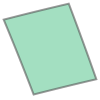

In [406]:
bbox

In [409]:
dem_path = 'dem.tif'
if not Path(dem_path).exists():
    dem_path = prepare_dem_geotiff(
        output_name='dem.tif',
        geometry=geom,
        epsg_code=epsg_code,
        pixel_size=0.001,
        height_above_ellipsoid=True
    )

#### Get DEM Interpolator

In [536]:
from osgeo import gdal

gdal.UseExceptions()

ds = gdal.Open(dem_path)
trans = ds.GetGeoTransform()  # In EPSG:4326
band = ds.GetRasterBand(1)
dem = band.ReadAsArray()

min_lon = trans[0]
max_lat = trans[3]
lon_res = trans[1]
lat_res = trans[5]

num_lats, num_lons = dem.shape

dem_lons = np.linspace(min_lon, min_lon + lon_res * num_lons, num_lons)
dem_lats = np.linspace(max_lat + lat_res * num_lats, max_lat, num_lats)[::-1]

dem_interp = sp.interpolate.RegularGridInterpolator((dem_lats, dem_lons), dem, bounds_error=False, fill_value=np.nan, method='cubic')

#### Convert from ECEF Coordinates to Geodetic Coordinates (Latitude, Longitude)

In [513]:
def ecef_to_latlon(X, Y, Z):
    lon = np.arctan2(Y, X) * 360 / (2 * pi)

    # Latitude and Height is where Newton-Raphson comes into play
    # See https://en.wikipedia.org/wiki/Geographic_coordinate_conversion#From_ECEF_to_geodetic_coordinates
    a = 6378137 # WGS84 Semi-major axis
    b = 6356752.31424518 # WGS84 Semi-minor axis
    e = 0.081819190842622 # WGS84 Eccentricity
    
    # Instead of doing iterations, we can apply Ferrari's solution
    ep2 = (a**2 - b**2) / b**2
    p = np.sqrt(X**2 + Y**2)
    F = 54 * b**2 * Z**2
    G = p**2 + (1 - e**2) * Z**2 - e**2 * (a**2 - b**2)
    c_ = (e**4 * F * p**2) / G**3
    s = np.power(1 + c_ + np.sqrt(c_**2 + 2 * c_), 1/3)
    k = s + 1 + (1 / s)
    P = F / (2 * k**2 * G**2)
    Q = np.sqrt(1 + 2 * e**4 * P)
    r_0 = (-P * e**2 * p) / (1 + Q)
    r_0 += np.sqrt((0.5 * a**2) * (1 + (1 / Q)) - ((P * (1 - e**2) * Z**2) / (Q * (1 + Q))) - (0.5 * P * p**2))
    U = np.sqrt((p - e**2 * r_0)**2 + Z**2)
    V_ = np.sqrt( (p - e**2 * r_0)**2 + (1 - e**2) * Z**2)
    z_0 = b**2 * Z / (a * V_)
    h = U * (1 - (b**2 / (a * V_)))
    lat = (np.arctan((Z + ep2*z_0) / p) * 360) / (2 * pi)

    return lat, lon, h

def get_radius_at_latitude(lat):
    # https://gscommunitycodes.usf.edu/geoscicommunitycodes/public/geophysics/Gravity/earth_shape.php
    flattening = 1/298.257223563
    a = 6378137
    return a * (1 - flattening * np.sin(lat)**2)

#### Setup Satellite TCN (tangent, cross-track, nadir) Coordinate System and Iteratively Solve the Range Doppler Equation

$T = R_{sat} + \alpha.t + \beta.m + \gamma.n$

In [580]:
def radar_to_map_coords(start_az_index, end_az_index, slant_ranges, packet_times, dem_interp, position_interp, velocity_interp, threshold=5e-2, max_iters=25):
    """Get Radar to Map Grid"""

    num_az = end_az_index - start_az_index
    num_rng = slant_ranges.size

    grid = np.zeros((num_az, num_rng, 5))

    for az_index in range(start_az_index, end_az_index):
        # Setup TCN (Tangent, Cross-track, Nadir) Coordinate System
        t0 = packet_times[az_index]

        P = pos_interp(t0)
        V = vel_interp(t0)

        sat_lat, sat_lon, sat_alt = ecef_to_latlon(P[0], P[1], P[2]) 

        R_geo = get_radius_at_latitude(sat_lat)
        R_sat = np.linalg.norm(P)
        v = V / np.linalg.norm(V)

        n = -P / np.linalg.norm(P)
        m = np.cross(n, V) / np.linalg.norm(np.cross(n, V)) # m replaces c in the spec
        t = np.cross(m, n)

        f_d = 0.0 # Assumes Zero-Doppler Geometry

        # Left looking = 1
        # Right looking = -1
        L = 1

        for rng_index in range(num_rng):
            R_0 = slant_ranges[rng_index]
            h_0 = 0.0
            h_from_dem = -500.0
            T = None
            inc = 0.0
            iters = 0
            while np.abs(h_from_dem - h_0) > threshold and iters < max_iters:
                h_0 = h_from_dem

                # Solve Range Doppler Equation
                gamma = R_sat / R_0
                gamma += R_0 / R_sat
                gamma -= ((h_0 + R_geo) / R_sat) * ((h_0 + R_geo) / R_0)
                gamma *= R_0 / 2

                alpha = f_d * wavelength * R_0 / (2 * np.linalg.norm(V))
                alpha -= gamma * np.dot(n, v)
                alpha /= np.dot(t, v)

                beta = -L * np.sqrt(R_0**2 - gamma**2 - alpha**2)

                T = P + alpha * t + beta * m + gamma * n

                # Update height estimate for the next iteration
                X, Y, Z = T
                lat, lon, _ = ecef_to_latlon(X, Y, Z)
                h_from_dem = dem_interp([lat, lon])[0]
    
                inc = np.dot(P, T) / (np.linalg.norm(P) * np.linalg.norm(T))
                
                iters += 1

            if iters >= max_iters - 1:
                print(f'Reached Maximum Number of Iterations for {az_index}, {rng_index}.')

            grid[az_index - start_az_index, rng_index] = X, Y, Z, h_from_dem, inc

    return grid

In [560]:
pos_interp = sp.interpolate.interp1d(times, positions, axis=0)
vel_interp = sp.interpolate.interp1d(times, velocities, axis=0)
packet_times = np.asarray(product['science']['LSAR']['RRSD']['swaths']['frequencyA']['txH']['UTCtime'])

start_az_index = 70000
end_az_index = 70001

grid = radar_to_map_coords(start_az_index, end_az_index, slant_ranges, packet_times, dem_interp, pos_interp, vel_interp)

In [705]:
import time

start_az_index = 70000
end_az_index = 70100

start_time = time.time()
grid = radar_to_map_coords(start_az_index, end_az_index, slant_ranges, packet_times, dem_interp, pos_interp, vel_interp)
end_time = time.time()

print(f'rdr2geo to {end_time-start_time}s for {end_az_index-start_az_index} azimuth lines.')

rdr2geo to 546.0373013019562s for 100 azimuth lines.


#### Delay Model

In [582]:
def get_tropo_delay(height, incidence_angle):
    D_0 = 2.3 # meters
    H = 6000  # meters
    return (2 / speed_of_light) * (D_0 / np.cos(incidence_angle)) * np.exp(-height / H)

In [600]:
def get_delays(start_az_index, end_az_index, grid, packet_times, position_interp, velocity_interp):
    """Get Delay `t_ijk`"""

    num_az = end_az_index - start_az_index
    num_rng = slant_ranges.size

    delays = np.zeros((num_az, num_rng, 3), dtype=np.float64)

    for az_index in range(start_az_index, end_az_index):

        # Setup TCN (Tangent, Cross-track, Nadir) Coordinate System
        t0 = packet_times[az_index]
        p_k = pos_interp(t0)
        v_k = vel_interp(t0)
        T = grid[az_index - start_az_index]

        for rng_index in range(num_rng):
            T_ij = T[rng_index]
            x_ij = T_ij[:3]
            h_ij = T_ij[3]
            inc = T_ij[4]
            p_ijk = np.abs(x_ij - p_k)

            t_atm = get_tropo_delay(h_ij, inc)
            t_ijk = t_atm + (2 * p_ijk + 2 * (x_ij - p_k) * (v_k / speed_of_light)) / (speed_of_light * (1 - (v_k**2 / speed_of_light**2)))

            delays[az_index - start_az_index, rng_index] = t_ijk

    return delays

In [706]:
delays = get_delays(start_az_index, end_az_index, grid, packet_times, pos_interp, vel_interp)

In [707]:
def knab_kernel(t, L, v):
    if t == 0:
        return 1

    phi = np.sin(pi * t) / (pi * t)
    cosh_inner = (pi * v * L / 2) * np.sqrt(1 - (2 * t / L)**2)
    phi *= np.cosh(cosh_inner) / np.cosh(pi * v * L / 2)

    return phi

In [712]:
delays.shape

(100, 52818, 3)

In [708]:
def interpolate_signals_to_grid(radar_data, delays, slant_ranges, range_bandwidth):
    kernel_offset = 4
    L = 2 * kernel_offset + 1
    kernel_bandwidth = L / range_bandwidth
    round_trip_delays = (2 * slant_ranges / speed_of_light)

    num_az, num_rng = radar_data.shape

    interpolated_radar_data = np.zeros((num_az, num_rng), dtype=np.complex64)

    swst = round_trip_delays[0]

    for az_index in range(num_az):
        for rng_index in range(num_rng):
            t_ijk = np.linalg.norm(delays[az_index, rng_index])
            n_0 = rng_index

            start_rng = n_0 - kernel_offset if n_0 - kernel_offset >= 0 else 0
            end_rng = n_0 + kernel_offset if n_0 + kernel_offset < num_rng else num_rng - 1

            signal_chip = radar_data[az_index][start_rng:end_rng]
            # FIXME: This doesn't feel right
            knabbed_delay = knab_kernel((rng_index / num_rng) - (t_ijk - swst), 9, kernel_bandwidth)

            interpolated_radar_data[az_index][rng_index] = np.sum(knabbed_delay * signal_chip)

    return interpolated_radar_data

In [713]:
interped_signals = interpolate_signals_to_grid(rc_subset[:100], delays, slant_ranges, range_bandwidth)

In [714]:
plot_signal_components(interped_signals[0])

In [697]:
plot_signal_components(rc_subset[0])

In [722]:
def back_project(radar_data, delays, center_freq):
    num_az, num_rng = radar_data.shape

    N = 10

    focused_data = np.zeros((num_az, num_rng), dtype=np.complex64)

    for az_index in range(num_az):
        for rng_index in range(num_rng):
            start_az = az_index - int(np.floor(0.5*N)) if az_index - 0.5*N >= 0 else 0
            end_az = az_index + int(np.floor(0.5*N)) if az_index + 0.5*N < num_az else num_az - 1

            t_ijk = np.asarray([np.linalg.norm(d) for d in delays[start_az:end_az, rng_index]])
            x_ijk = radar_data[start_az:end_az, rng_index]

            phase_product = np.exp(2j * pi * center_freq * t_ijk) * x_ijk
            focused_data[az_index, rng_index] = np.sum(phase_product)

    return focused_data

In [723]:
focused = back_project(interped_signals, delays, center_freq)

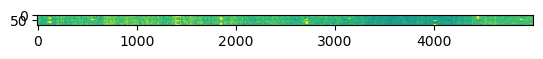

In [730]:
# %matplotlib qt
%matplotlib inline
plt.imshow(np.abs(rc_subset[:100, num_rng // 2:5000 + num_rng // 2]), vmin=0, vmax=3)
plt.show()

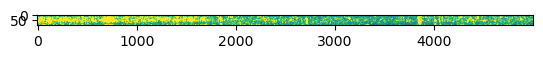

In [728]:
# %matplotlib qt
%matplotlib inline
plt.imshow(np.abs(focused[:, num_rng // 2:5000 + num_rng // 2]), vmin=0, vmax=10)
plt.show()